In [1]:
from bs4 import BeautifulSoup as soup
import numpy as np
import pandas as pd
from urllib.request import urlopen as uReq
import datetime
import matplotlib.pyplot as plt
import scipy as scipy
from scipy.integrate import simps
import scipy.signal

plt.rcParams["figure.figsize"] = (15, 10)


In [2]:
#helper function to scrape CDIP vertical displacement data
def get_ut_array(d1):
    #get the unix timestamp array to use as the index
    #get unix time stamp of the d1
    #dt1 = datetime.datetime.strptime(d1, '%Y%m%d%H%M%S')
    ut1 = d1.timestamp()
    
    #get unix time stamp of 1 hour after d1
    dt2 = d1 + datetime.timedelta(hours=1)
    ut2 = dt2.timestamp()
    
    #construct the array
    ut_array = np.arange(start=ut1, stop=ut2, step=1)
    return ut_array
  
def get_pier_data(d1):
    #get the html file of the website
    d1 = d1.strftime('%Y%m%d%H%M%S')
    url=f'https://cdip.ucsd.edu/themes/?pb=1&d2=p70&u2=s:073:st:1:v:rd_plot:dt:{d1}:t:data'
    uClient = uReq(url)
    page_html = uClient.read()
    uClient.close()
    page_soup = soup(page_html, 'html.parser')
    
    #get the element contains the data
    y = page_soup.findAll('pre', {'style':'text-align: left;'})[0]
    
    #store the data in a array
    data = y.text.split("\n",25)[25]
    array = data.split()
    
    return array

def get_pier_hour_data(d1):
    #get the data of every second in one hour
    ut_array = get_ut_array(d1)
    data_array = get_pier_data(d1)
    
    #construct a data frame using the data scraped
    data = {'Unix Timestamp':ut_array, 'Data':data_array}
    df = pd.DataFrame(data=data)
    return df

def get_time_range(d1, d2):
    #return the time window for scraping XX:20:00 to XX:20:00 because of the format of the website
    d1_string = d1.strftime('%Y%m%d%H')
    d1 = datetime.datetime.strptime(d1_string, '%Y%m%d%H')-datetime.timedelta(hours=1)+datetime.timedelta(minutes=20)
    d1 = d1.replace(tzinfo=datetime.timezone.utc)
    d2_string = d2.strftime('%Y%m%d%H')
    d2 = datetime.datetime.strptime(d2_string, '%Y%m%d%H')+datetime.timedelta(hours=1)+datetime.timedelta(minutes=20)
    d2 = d2.replace(tzinfo=datetime.timezone.utc)
    
    return d1, d2

def daterange(start_date, end_date):
    #iterate through a period of time by 1 hour
    delta = datetime.timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta

def get_data(start_time, end_time):
    #get the data between start_time and end_time(any customized start_time and end_time)
    print("Getting Data")
    d1, d2 = get_time_range(start_time, end_time)
    
    result = pd.DataFrame()
    for i in daterange(d1, d2):
        df = get_pier_hour_data(i)
        result = result.append(df)
    
    #only keep the data between start_time and end_time
    result = result[(result['Unix Timestamp'] >= start_time.timestamp()) & (result['Unix Timestamp'] <= end_time.timestamp())]
    #result.set_index('Unix Timestamp', inplace=True)
    result.reset_index(inplace=True)
    result.drop(columns = 'index', inplace=True)
    print("Done")
    return result

### Scrape CDIP Hs Data

Hs in meters
Date and time are in UTC

In [3]:
CDIP_hs_df = pd.read_html('https://cdip.ucsd.edu/themes/?pb=1&tz=UTC&ll=1&un=0&d2=p70&u2=s:073:st:1:v:parameter:dt', flavor='html5lib')[3]
CDIP_hs_df

,Date(UTC),Hs(m),Tp(s),Ta(s),Depth(m),Wind sp(m/s),Wind dir(deg)
0,Date(UTC),Hs(m),Tp(s),Ta(s),Depth(m),Wind sp(m/s),Wind dir(deg)
1,2021-08-05 17:45,0.85,7.31,5.77,5.37,0.1,314
2,2021-08-05 16:45,0.86,7.53,5.73,5.45,0.1,221
3,2021-08-05 15:45,0.82,7.11,5.88,5.46,0.8,31
4,2021-08-05 14:45,0.88,7.76,5.88,5.37,1.3,41
...,...,...,...,...,...,...,...
4842,2021-01-15 22:45,0.87,13.47,8.25,4.51,2.0,18
4843,2021-01-15 21:45,0.89,9.85,8.44,4.92,4.6,14
4844,2021-01-15 20:45,0.88,12.19,8.96,5.39,0.3,41
4845,2021-01-15 19:45,0.89,11.64,9.00,5.84,0.8,260


### Scrape CDIP vertical displacement data
Vertical Displacement are in centimenters

In [4]:
#choose the range of period by specifying the start and end time
start_time= datetime.datetime(year=2021, month=7, day=22, hour=3, minute=45, second=0).replace(tzinfo=datetime.timezone.utc)
end_time = datetime.datetime(year=2021, month=7, day=22, hour=4, minute=45, second=0).replace(tzinfo=datetime.timezone.utc)
vertical_displacement_df = get_data(start_time, end_time)

Getting Data
Done


In [5]:
vertical_displacement_df

,Unix Timestamp,Data
0,1.626926e+09,634.2
1,1.626926e+09,629.3
2,1.626926e+09,627.9
3,1.626926e+09,628.4
4,1.626926e+09,626.5
...,...,...
3596,1.626929e+09,584.7
3597,1.626929e+09,569.4
3598,1.626929e+09,570.6
3599,1.626929e+09,587.9


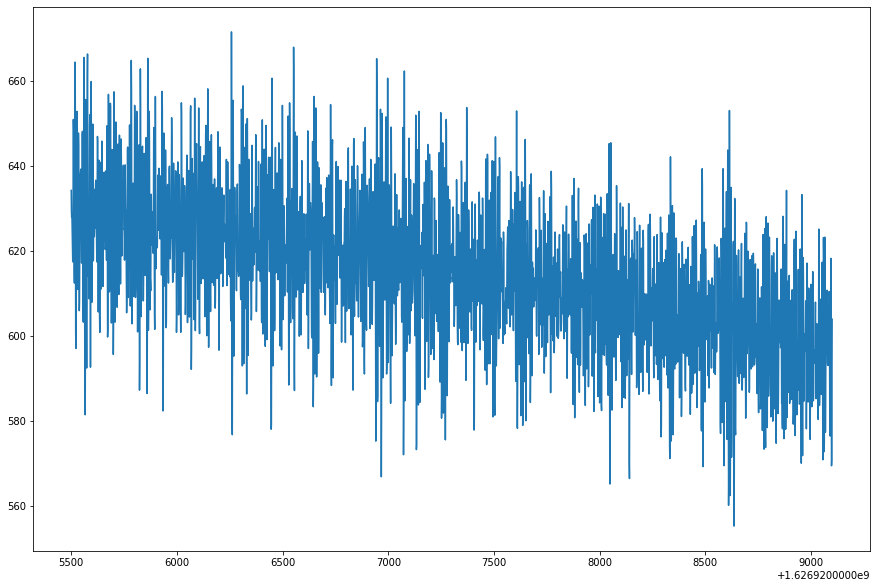

In [6]:
plt.plot([int(t) for t in vertical_displacement_df['Unix Timestamp']], [float(x) for x in vertical_displacement_df['Data']])

### Spectral Analysis

In [32]:
#Spectral Analysis Helper Functions
def generate_cos_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    #2pi because np.sin takes radians
    y = np.cos((2 * np.pi) * frequencies)
    return x, y

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    #2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

def get_m0_hm0(x, y, minFreq=1e-2):
    m0 = scipy.integrate.simps(y[x > minFreq], x[x > minFreq])
    hm0 = 4 * np.sqrt(m0)
    return m0, hm0
# hm0 = sig wave height
# m0 = area under curve
def get_H13(x, y):
    time = x
    column = (y)
    column_det = scipy.signal.detrend(column)
    waves = column_det - column_det.mean()
    pkslocs, _ = scipy.signal.find_peaks(waves)
    troughlocs, _ = scipy.signal.find_peaks(-waves)
    peaks = waves[pkslocs]
    troughs = waves[troughlocs]
    plt.rcParams["figure.figsize"] = (20, 8)
    plt.scatter(troughlocs/rate,troughs,color='orange')
    plt.scatter(pkslocs/rate,peaks, color='red')
    plt.plot(time,waves)
    
    if len(peaks) > len(troughs): #make the arrays the same size
        peaks = peaks[:len(troughs)]
    if len(troughs) > len(peaks):
        troughs = troughs[:len(peaks)]

    Hs = peaks - troughs
    cutoff13 = np.percentile(Hs,200/3)
    Hs13 = Hs[Hs >= cutoff13]
    Sig_Height13 = Hs13.mean()

    return Sig_Height13
# H1/3 = avg of the upper 1/3 of the waves

In [33]:
#Generate Test Data
rate = 1
duration = 3600
x1, y1 = generate_sine_wave(5, rate, duration) 
x2, y2 = generate_cos_wave(0.1, rate, duration)
x3, y3 = generate_sine_wave(0.03, rate, duration)

x = x1
y = y1*1e-2 + y2*4 + y3*2

Text(0, 0.5, 'Vertical Displacement')

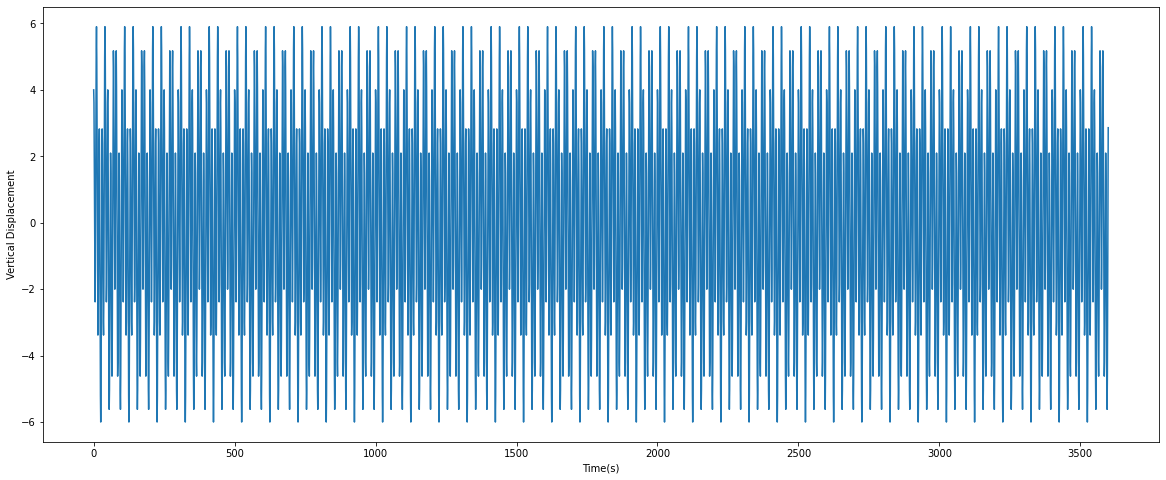

In [34]:
#Plot test data
plt.plot(x, y)
plt.xlabel('Time(s)')
plt.ylabel('Vertical Displacement')

9.484603072170728

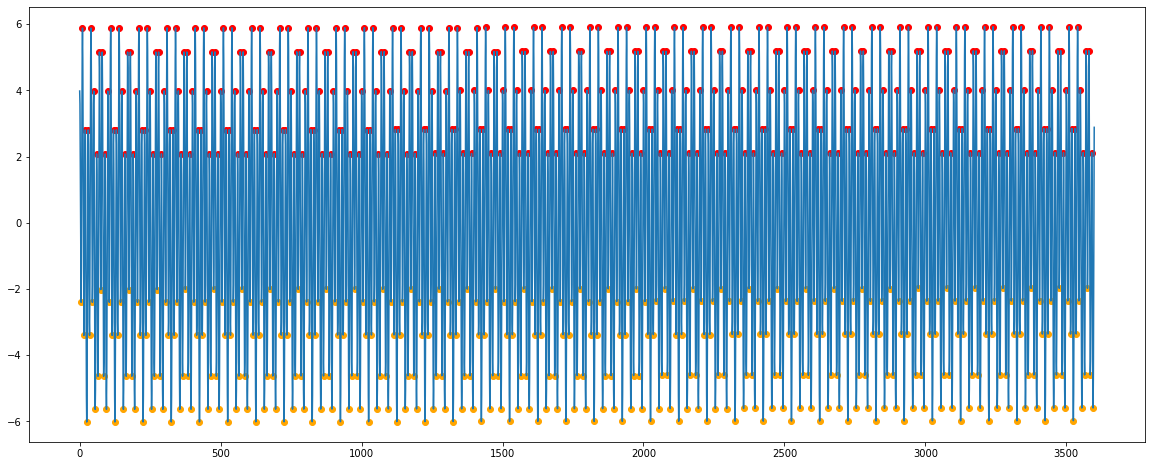

In [35]:
get_H13(x, y)

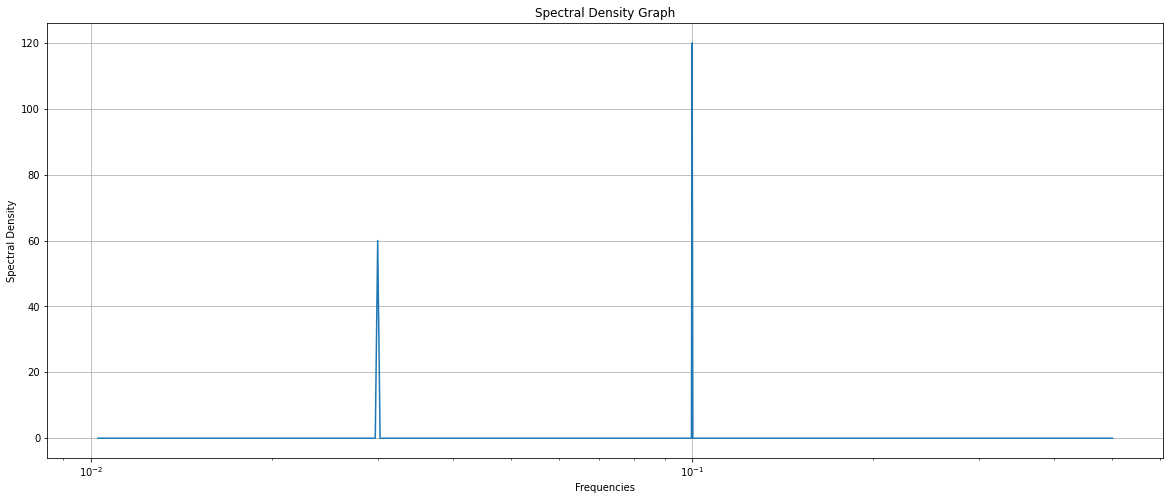

In [36]:
#FFT
N = len(y)
rate = rate
yf = np.abs(np.fft.rfft(y - np.mean(y), norm='ortho')) # magnitudes of the results of the transformation
xf = np.fft.rfftfreq(N, 1/rate) # the frequencies on the x-axis
# plt.plot(xf, np.abs(yf))
plt.semilogx(xf[xf > 1e-2], np.abs(yf)[xf > 1e-2])
plt.xlabel('Frequencies')
plt.ylabel('Spectral Density')
plt.title('Spectral Density Graph')
plt.grid()

In [37]:
#Calculate m0 and hm0
m0, hm0 = get_m0_hm0(xf, yf)
m0, hm0

(0.05000000000007312, 0.8944271910005699)

In [38]:
cdip_t = np.array([int(t) for t in vertical_displacement_df['Unix Timestamp']])
#scraped cdip time^
cdip_d = np.array([float(x) for x in vertical_displacement_df['Data']]) / 100
#scraped cdip displacement^


cdip_t = cdip_t - cdip_t[0]

In [39]:
window = signal.hann(3601)
cdip_d = cdip_d*window

0.3619037669865754

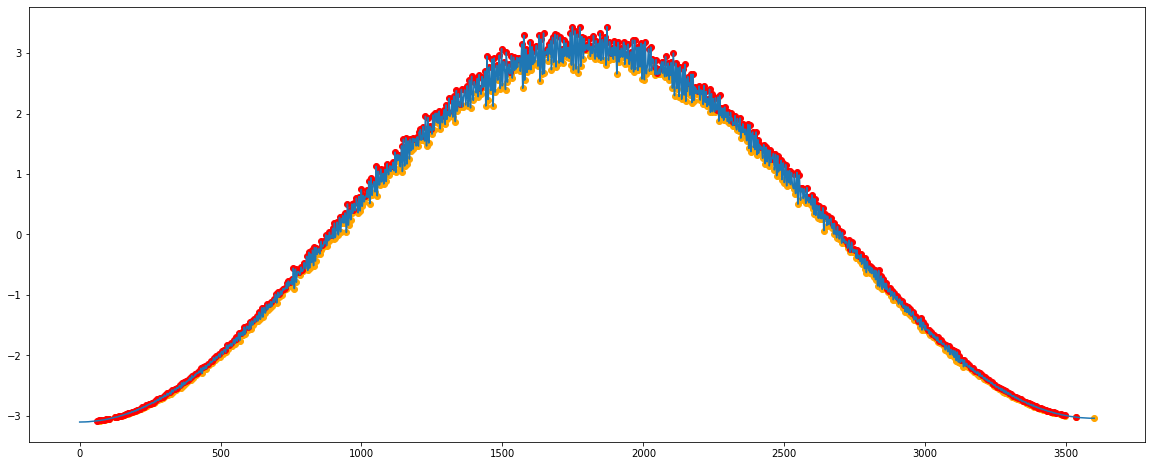

In [40]:
get_H13(cdip_t, cdip_d)

In [41]:
cdip_d_detrend = scipy.signal.detrend(cdip_d) # removes overall trends but maintains sin waves
cdip_h = np.abs(np.fft.rfft(cdip_d_detrend, norm='ortho')) # result of fft ~ yf
cdip_f = np.fft.rfftfreq(len(cdip_d), 1) # result of fft ~ xf

In [42]:
# cdip_h = cdip_h
freq, psd = scipy.signal.welch(cdip_h, fs=300, window='hann')

In [43]:
get_m0_hm0(cdip_f, cdip_h)

(0.02386906915544562, 0.6179847137972994)

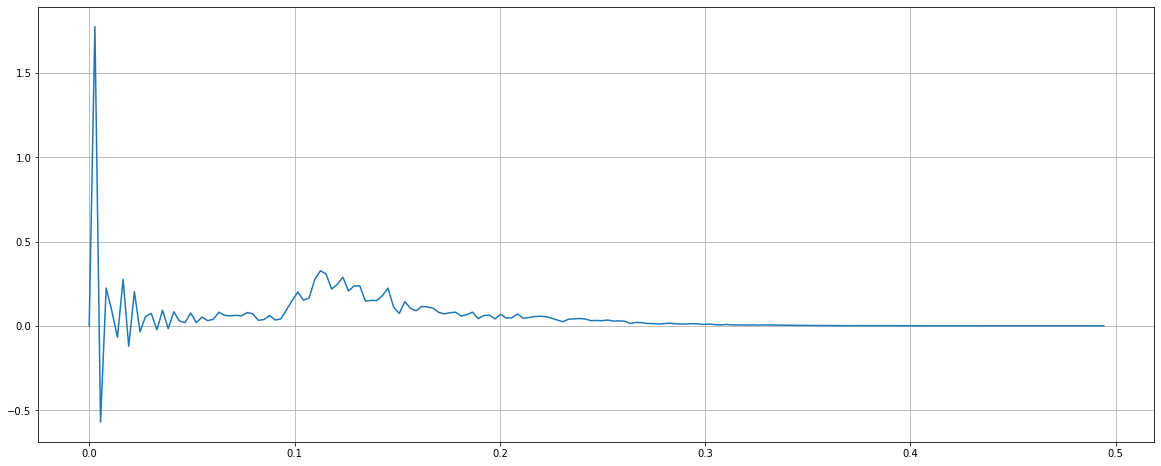

In [44]:
cdip_h_smoothed = np.zeros(len(cdip_h))
for i in range(1, len(cdip_h) - 1):
    cdip_h_smoothed[i] = 0.25 * cdip_h[i - 1] + 0.5 * cdip_h[i] + 0.25 * cdip_h[i + 1]

decimationFactor = 10
plt.plot(scipy.signal.decimate(cdip_f, decimationFactor), scipy.signal.decimate(cdip_h, decimationFactor))
plt.grid()
# smooth out graph^ makes it look nicer basically

In [45]:
m0 = scipy.integrate.simps(cdip_h, cdip_f)
hm0 = 4 * np.sqrt(m0)
m0, hm0

(0.05889358910858816, 0.9707200552875225)

Compare the above plot to https://cdip.ucsd.edu/themes/?pb=1&d2=p70&u2=s:073:st:1:v:spectral_plot:dt:202107210445:t:plot

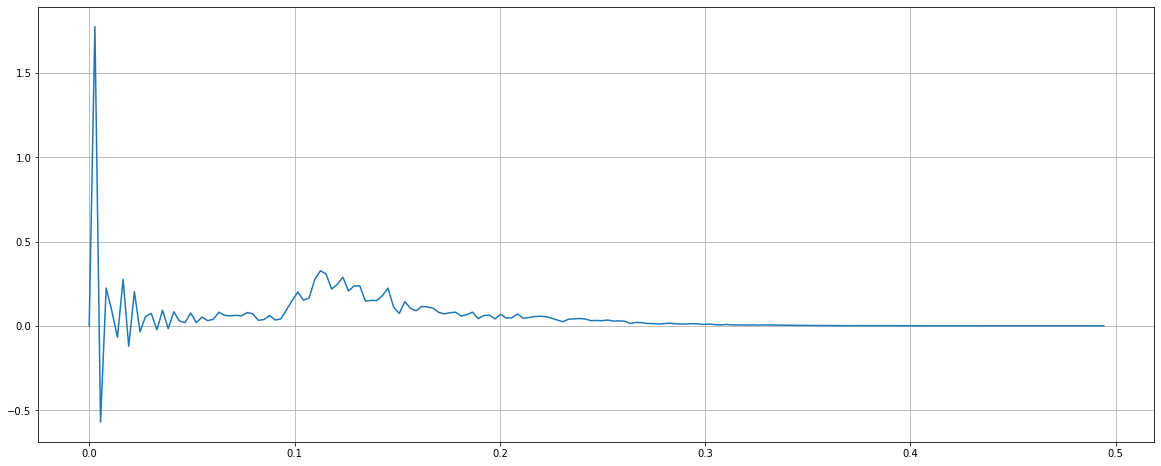

In [46]:
# window = signal.hann(1801)
# cdip_h = cdip_h*window

cdip_h_smoothed = np.zeros(len(cdip_h))
for i in range(1, len(cdip_h) - 1):
    cdip_h_smoothed[i] = 0.25 * cdip_h[i - 1] + 0.5 * cdip_h[i] + 0.25 * cdip_h[i + 1]

decimationFactor = 10
plt.plot(scipy.signal.decimate(cdip_f, decimationFactor), scipy.signal.decimate(cdip_h, decimationFactor))
plt.grid()
# smooth out graph^ makes it look nicer basically

## Hanning Window

In [21]:
from scipy import signal
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt

In [ ]:
window

In [ ]:
window = signal.hann(1801)
plt.plot(window)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

In [ ]:
plt.figure()
A = fft(window, 2048) / (len(window)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
plt.plot(freq, response)
plt.axis([-0.5, 0.5, -120, 0])
plt.title("Frequency response of the Hann window")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")

In [ ]:
freqs, psd = scipy.signal.welch(y, fs=300, window='hann')
x = freqs
y = psd

In [ ]:
plt.plot(x, y)

In [ ]:
cdip_t

In [4]:
df = pd.read_csv('SA_test_diff.csv')
df

,Unnamed: 0,Date(UTC),Hs(m),H13,Hm0_Unwindowed,Hm0_Hann,Hm0_Tukey
0,200,2021-08-01 07:45,0.84,0.399737,0.716229,0.561488,0.654187
1,201,2021-08-01 06:45,0.88,0.434499,0.741343,0.575381,0.667839
2,202,2021-08-01 05:45,0.93,0.458014,0.755640,0.594592,0.689337
3,203,2021-08-01 04:45,0.88,0.457122,0.750967,0.583620,0.685306
4,204,2021-08-01 03:45,0.88,0.414122,0.722904,0.559667,0.654591
...,...,...,...,...,...,...,...
1995,2195,2021-05-10 03:45,0.83,0.564245,0.784798,0.611298,0.711839
1996,2196,2021-05-10 02:45,0.81,0.533854,0.777261,0.596266,0.702342
1997,2197,2021-05-10 01:45,0.76,0.533983,0.775829,0.611479,0.706639
1998,2198,2021-05-10 00:45,0.85,0.571825,0.803459,0.643223,0.736919


In [10]:
(df['Hs(m)'] - df['Hm0_Unwindowed']).mean()

-0.025933736168254402

In [11]:
(df['Hs(m)'] - df['Hm0_Hann']).mean()

0.1336849255469296

In [12]:
(df['Hs(m)'] - df['Hm0_Tukey']).mean()

0.04036602256707836

In [13]:
df['Hs(m)'].mean()

0.7020720720720706

In [6]:
df['Hm0_Unwindowed'].mean()

0.7280227856887657

In [7]:
df['Hm0_Hann'].mean()

0.5684046637793625

In [8]:
df['Hm0_Tukey'].mean()

0.661725052640375

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pylab import rcParams
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

In [15]:
def plot_distribution(inp):
    plt.figure()
    ax = sns.distplot(inp)
    plt.axvline(np.mean(inp), color="k", linestyle="dashed", linewidth=5)
    _, max_ = plt.ylim()
    plt.text(
        inp.mean() + inp.mean() / 10,
        max_ - max_ / 10,
        "Mean: {:.2f}".format(inp.mean()),
    )
    return plt.figure

### Hs(m)

/Users/nimayazdani/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

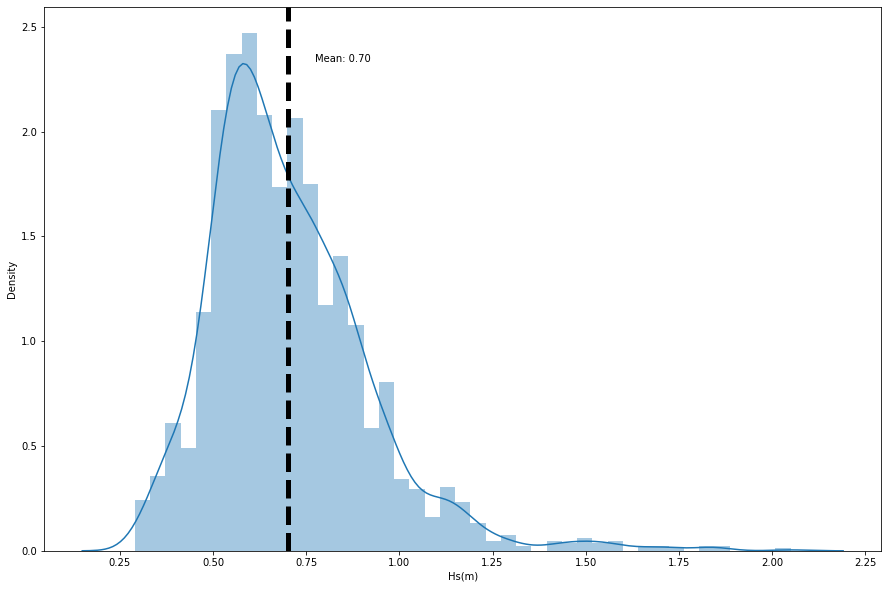

In [18]:
plot_distribution(df['Hs(m)'])

### Unwindowed

/Users/nimayazdani/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

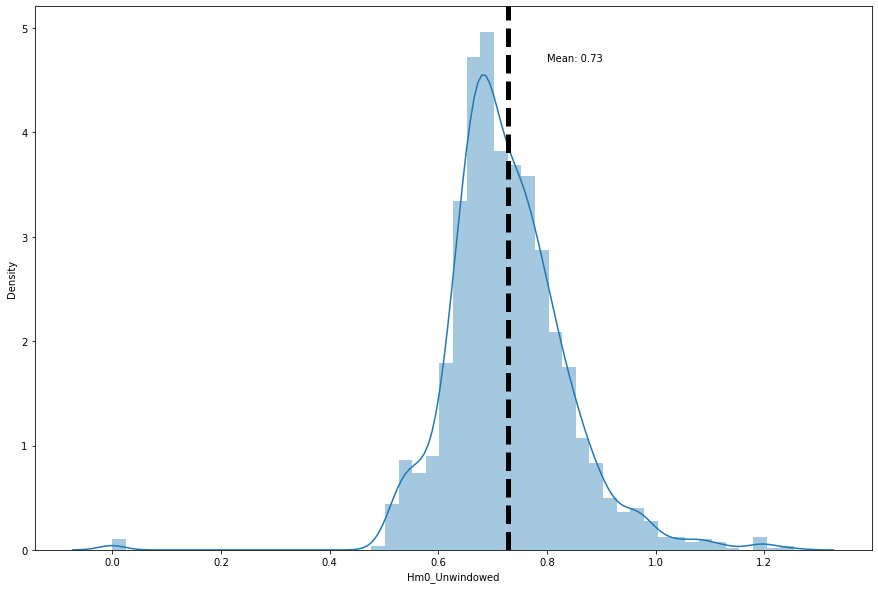

In [19]:
plot_distribution(df['Hm0_Unwindowed'])


### Hann Window

/Users/nimayazdani/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

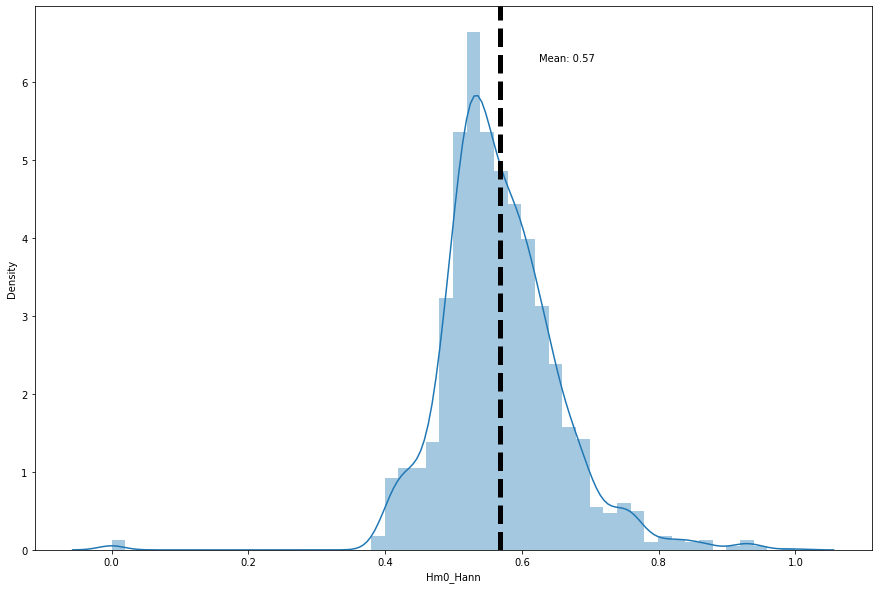

In [20]:
plot_distribution(df['Hm0_Hann'])


### Tukey Window

/Users/nimayazdani/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

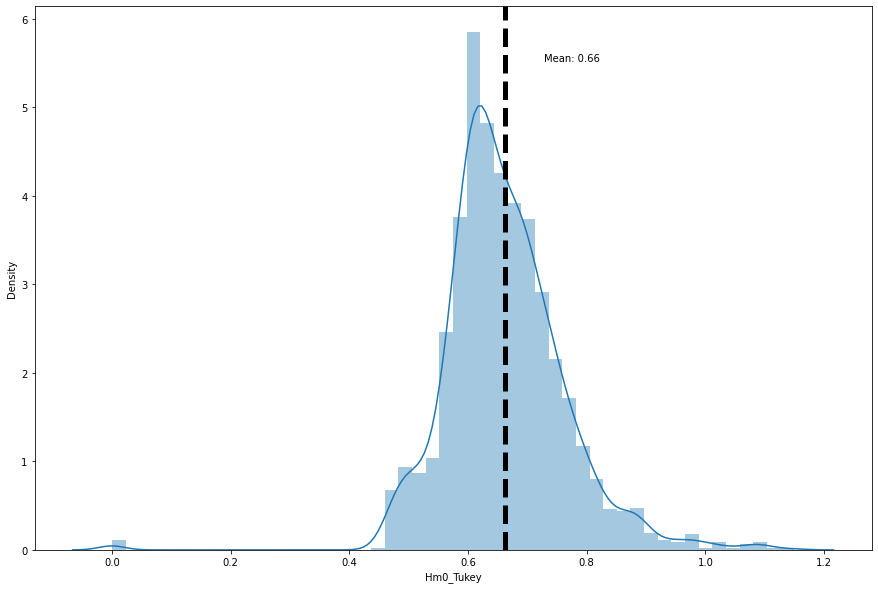

In [21]:
plot_distribution(df['Hm0_Tukey'])

### Blue: Hs(m)
### Orange: Unwindowed
### Green: Hann Window
### Red: Tukey Window

/Users/nimayazdani/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nimayazdani/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nimayazdani/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

[Text(0.5, 0, 'Significant Wave Heights'), Text(0, 0.5, 'Density')]

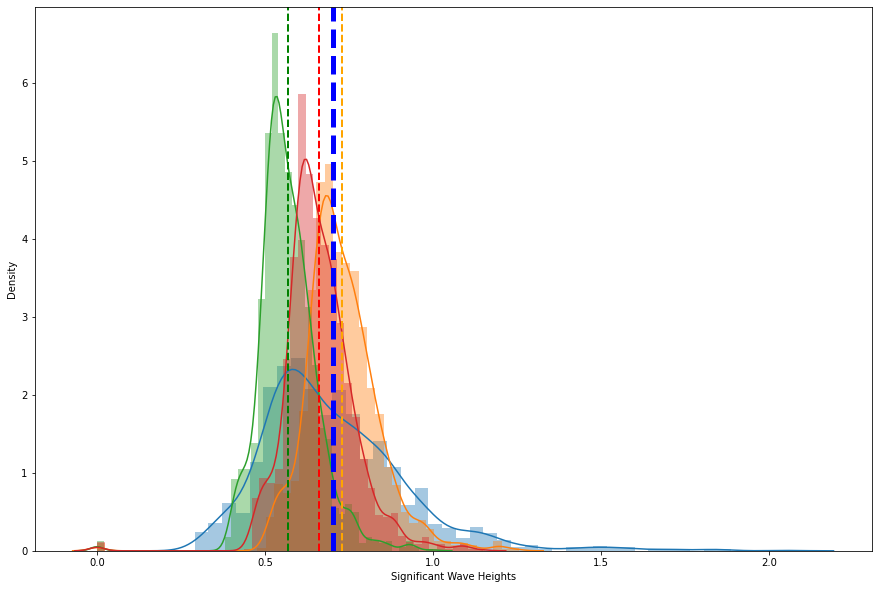

In [30]:
plt.figure()
ax1 = sns.distplot(df['Hs(m)'])
ax2 = sns.distplot(df['Hm0_Unwindowed'])
ax3 = sns.distplot(df['Hm0_Hann'])
ax4 = sns.distplot(df['Hm0_Tukey'])


plt.axvline(np.mean(df['Hs(m)']), color='b', linestyle='dashed', linewidth=5)
plt.axvline(np.mean(df['Hm0_Unwindowed']), color='orange', linestyle='dashed', linewidth=2)
plt.axvline(np.mean(df['Hm0_Hann']), color='g', linestyle='dashed', linewidth=2)
plt.axvline(np.mean(df['Hm0_Tukey']), color='r', linestyle='dashed', linewidth=2)
ax4.set(xlabel='Significant Wave Heights', ylabel='Density')

In [85]:
def compare_2_groups(arr_1, arr_2, alpha, sample_size):
    stat, p = ttest_ind(arr_1, arr_2)
#     print('Statistics=%.3f, p=%.3f' % (stat, p))
#     if p > alpha:
#         print('Same distributions (fail to reject H0)')
#     else:
#         print('Different distributions (reject H0)')
    return p

In [111]:
ans = []
for i in range(10000):
    sample_size = 100
    Hs_sampled = np.random.choice(df['Hs(m)'], sample_size)
    Unwindowed_sampled = np.random.choice(df['Hm0_Unwindowed'], sample_size)
    ans.append(compare_2_groups(Hs_sampled, Unwindowed_sampled, 0.05, sample_size))
newlist = [x for x in ans if math.isnan(x) == False]
np.mean(newlist)

0.3424904383860104

In [112]:
ans = []
for i in range(10000):
    sample_size = 100
    Hs_sampled = np.random.choice(df['Hs(m)'], sample_size)
    Hann_sampled = np.random.choice(df['Hm0_Hann'], sample_size)
    ans.append(compare_2_groups(Hs_sampled, Unwindowed_sampled, 0.05, sample_size))
newlist = [x for x in ans if math.isnan(x) == False]
np.mean(newlist)

0.3906795678036387

In [113]:
ans = []
for i in range(10000):
    sample_size = 100
    Hs_sampled = np.random.choice(df['Hs(m)'], sample_size)
    Hann_sampled = np.random.choice(df['Hm0_Tukey'], sample_size)
    ans.append(compare_2_groups(Hs_sampled, Unwindowed_sampled, 0.05, sample_size))
newlist = [x for x in ans if math.isnan(x) == False]
np.mean(newlist)

0.3854120827183414

In [110]:
# sample_size = 100
# Hs_sampled = np.random.choice(df['Hs(m)'], sample_size)
# Tukey_sampled = np.random.choice(df['Hm0_Tukey'], sample_size)
# compare_2_groups(Hs_sampled, Unwindowed_sampled, 0.05, sample_size)

In [103]:
import math